 # Chapter 08: Transfer Learning with `prior_from_idata` and Hierarchical Modeling

 In the previous chapter, we demonstrated how to improve short time series forecasting by transferring learned seasonality from a long related time series using `tune_method="parametric"`. That approach extracts the posterior **mean and standard deviation** from the source model and uses them as the parameters of a new Normal prior.

 In this chapter, we explore a more powerful alternative: `tune_method="prior_from_idata"`. Instead of summarizing the posterior into two numbers (mean, std), this method uses the **full posterior distribution** from the source model as the prior for the target model — preserving correlations between parameters and any non-Gaussian structure in the posterior.

 We also demonstrate how to **combine hierarchical modeling with transfer learning**: fitting a single joint model over both the long temperature series and the short bike sales series, with partial pooling on the yearly seasonality informed by the temperature model's posterior. This is one of vangja's most powerful features for short time series forecasting.

 > **Reference**: The `prior_from_idata` functionality is provided by [pymc-extras](https://www.pymc.io/projects/extras/en/stable/generated/pymc_extras.utils.prior.prior_from_idata.html). It was inspired by the [Updating Priors](https://www.pymc.io/projects/examples/en/latest/howto/updating_priors.html) example in PyMC, which demonstrates how to iteratively update priors with posterior knowledge from previous analyses.

 ## Overview

 We'll cover three approaches in this notebook:
 1. **Recap**: Fit the temperature model to learn yearly seasonality (same as Chapter 07)
 2. **`prior_from_idata` transfer**: Transfer the full posterior to the bike sales model
 3. **Hierarchical + transfer learning**: Fit a joint model over both series with partial pooling and informed priors — the most powerful approach

 ## Setup and Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from vangja import FlatTrend, FourierSeasonality
from vangja.datasets import load_citi_bike_sales, load_nyc_temperature
from vangja.utils import metrics

print("Imports successful!")

Imports successful!


 ---

 ## Step 1: Load Data and Fit the Temperature Model

 This step is identical to Chapter 07. We load the NYC temperature and Citi Bike sales datasets, create the short training set, and fit a temperature model using MCMC to learn yearly seasonality. The MCMC posterior will then be used in the transfer learning steps that follow.

In [3]:
# Load the datasets
temp_df = load_nyc_temperature()
sales_df = load_citi_bike_sales()

# Match the temperature data to the sales date range (as in the original Tim Radtke blog post)
temp_df = temp_df[
    (temp_df["ds"] >= sales_df["ds"].min()) & (temp_df["ds"] <= sales_df["ds"].max())
]

print("Temperature data:")
print(f"  Shape: {temp_df.shape}")
print(f"  Date range: {temp_df['ds'].min().date()} to {temp_df['ds'].max().date()}")

print("\nSales data:")
print(f"  Shape: {sales_df.shape}")
print(f"  Date range: {sales_df['ds'].min().date()} to {sales_df['ds'].max().date()}")

Temperature data:
  Shape: (822, 2)
  Date range: 2013-07-01 to 2015-09-30

Sales data:
  Shape: (822, 2)
  Date range: 2013-07-01 to 2015-09-30


In [4]:
# Train/test split: use only the first ~3 months for training
train_test_date = pd.to_datetime("2013-10-15")

sales_train = sales_df[sales_df["ds"] < train_test_date].copy()
sales_test = sales_df[sales_df["ds"] >= train_test_date].copy()

print(
    f"Training period: {sales_train['ds'].min().date()} to {sales_train['ds'].max().date()}"
)
print(f"Training samples: {len(sales_train)} days")
print(
    f"\nTest period: {sales_test['ds'].min().date()} to {sales_test['ds'].max().date()}"
)
print(f"Test samples: {len(sales_test)} days")

Training period: 2013-07-01 to 2013-10-14
Training samples: 106 days

Test period: 2013-10-15 to 2015-09-30
Test samples: 716 days


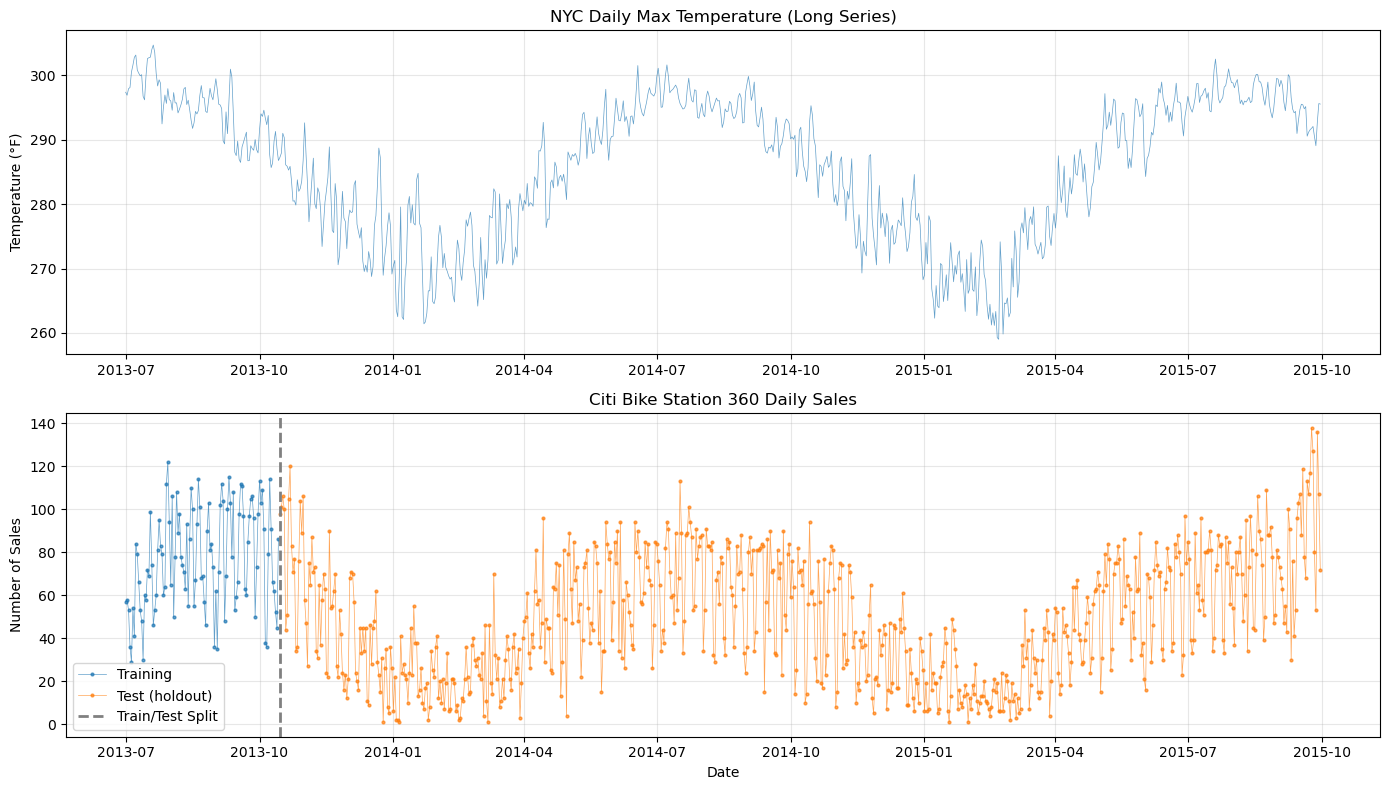

In [5]:
# Visualize both datasets and the train/test split
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Temperature
axes[0].plot(temp_df["ds"], temp_df["y"], "C0-", linewidth=0.5, alpha=0.7)
axes[0].set_title("NYC Daily Max Temperature (Long Series)")
axes[0].set_ylabel("Temperature (°F)")
axes[0].grid(True, alpha=0.3)

# Sales with train/test split
axes[1].plot(
    sales_train["ds"],
    sales_train["y"],
    "C0o-",
    markersize=2,
    linewidth=0.5,
    alpha=0.7,
    label="Training",
)
axes[1].plot(
    sales_test["ds"],
    sales_test["y"],
    "C1o-",
    markersize=2,
    linewidth=0.5,
    alpha=0.7,
    label="Test (holdout)",
)
axes[1].axvline(
    train_test_date, color="gray", linestyle="--", linewidth=2, label="Train/Test Split"
)
axes[1].set_title("Citi Bike Station 360 Daily Sales")
axes[1].set_ylabel("Number of Sales")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

 ### Fit the Temperature Model with MCMC

 We use a simple `FlatTrend + FourierSeasonality` model and fit it with NUTS (MCMC) to get full posterior samples. These samples will serve as the basis for transfer learning.

In [6]:
# Temperature model: flat trend + yearly seasonality
temp_model = FlatTrend() + FourierSeasonality(period=365.25, series_order=6)

print("Fitting temperature model with NUTS...")
temp_model.fit(temp_df, method="nuts", scaler="minmax")

# Get predictions to visualize the fit
temp_pred = temp_model.predict(horizon=0, freq="D")
print("Done!")

Fitting temperature model with NUTS...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ft_0 - intercept, fs_0 - beta(p=365.25,n=6), sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Done!


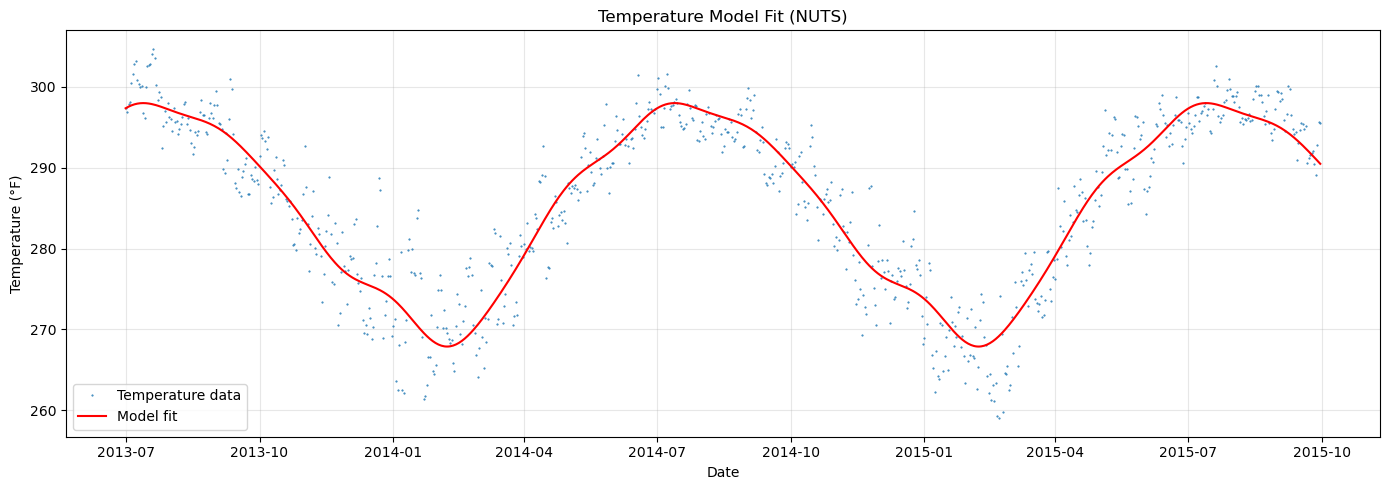

In [7]:
# Visualize temperature model fit
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(temp_df["ds"], temp_df["y"], "C0.", markersize=1, label="Temperature data")
ax.plot(temp_pred["ds"], temp_pred["yhat_0"], "r-", linewidth=1.5, label="Model fit")

ax.set_title("Temperature Model Fit (NUTS)")
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°F)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

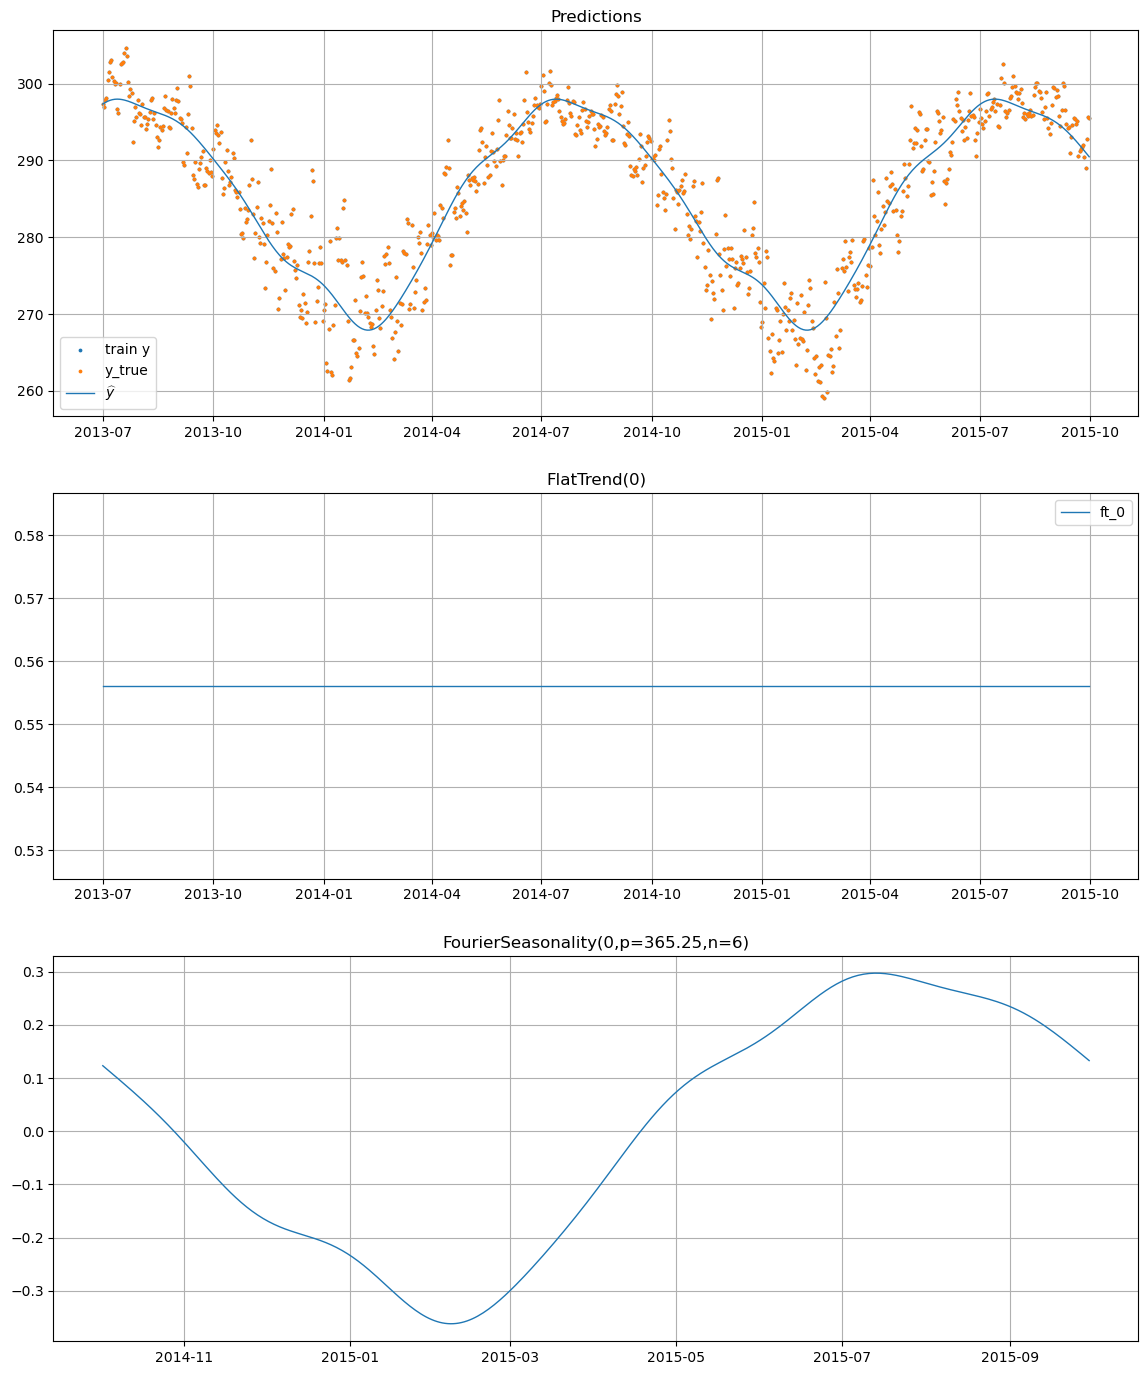

In [8]:
# Component decomposition
temp_model.plot(temp_pred, y_true=temp_df)

 ---

 ## Step 2: Transfer Learning with `prior_from_idata`

 ### What is `prior_from_idata`?

 In Chapter 07, we used `tune_method="parametric"`, which transfers knowledge by:
 1. Computing the **mean** and **standard deviation** of each posterior parameter
 2. Using these as the parameters of an independent Normal prior: $\beta_i^{\text{new}} \sim \text{Normal}(\mu_i, \sigma_i)$

 This is simple and effective, but it **discards** two important aspects of the posterior:
 - **Correlations** between parameters (e.g., the sine and cosine terms at the same frequency are often correlated)
 - **Non-Gaussian structure** (e.g., skewness, multimodality)

 The `tune_method="prior_from_idata"` approach instead uses the [prior_from_idata](https://www.pymc.io/projects/extras/en/stable/generated/pymc_extras.utils.prior.prior_from_idata.html) function from **pymc-extras**, which:
 1. Takes the full MCMC posterior samples from the source model
 2. Fits a **multivariate Normal distribution** to the posterior samples
 3. Creates a PyMC random variable from this distribution that can serve as the prior in the new model

 This means the new model's prior is a **multivariate Normal approximation** of the source model's full posterior — preserving the covariance structure between all parameters.

 Mathematically, instead of:

 $$\beta_i^{\text{new}} \sim \text{Normal}(\mu_i, \sigma_i) \quad \text{(independent)}$$

 we get:

 $$\boldsymbol{\beta}^{\text{new}} \sim \text{MultivariateNormal}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$$

 where $\boldsymbol{\mu}$ is the posterior mean vector and $\boldsymbol{\Sigma}$ is the full posterior covariance matrix.

 ### When to use `prior_from_idata` vs `parametric`

 | Aspect | `parametric` | `prior_from_idata` |
 |--------|-------------|-------------------|
 | **What it transfers** | Mean & std per parameter | Full covariance structure |
 | **Prior shape** | Independent Normal | Multivariate Normal |
 | **Correlations** | ❌ Discarded | ✅ Preserved |
 | **Complexity** | Simple | More complex |
 | **Inference method** | Works with MAP, ADVI, NUTS | Works with MAP, ADVI, NUTS |
 | **Source model** | MCMC or VI required | MCMC or VI required |
 | **Best for** | Quick prototyping, when correlations don't matter | When parameter correlations are important |

 For Fourier seasonality transfer, `prior_from_idata` is typically the better choice because the sine and cosine coefficients at each frequency **are** correlated — they jointly determine the phase and amplitude of each harmonic.

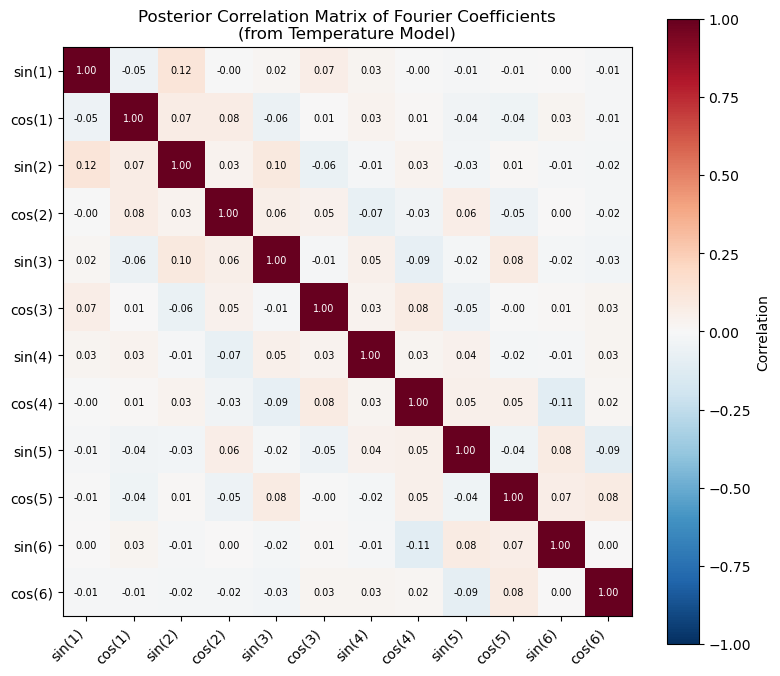

Non-zero off-diagonal correlations show that parametric transfer
(which assumes independence) discards valuable information.


In [9]:
# Let's visualize the correlation structure in the temperature posterior
# to understand why prior_from_idata matters

beta_key = "fs_0 - beta(p=365.25,n=6)"
beta_posterior = temp_model.trace["posterior"][beta_key]

# Reshape to (n_samples, n_coefficients)
beta_samples = beta_posterior.values.reshape(-1, 12)

# Compute correlation matrix
corr_matrix = np.corrcoef(beta_samples.T)

fig, ax = plt.subplots(figsize=(8, 7))
labels = [f"{'sin' if i % 2 == 0 else 'cos'}({i // 2 + 1})" for i in range(12)]
im = ax.imshow(corr_matrix, cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_xticks(range(12))
ax.set_yticks(range(12))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)
ax.set_title(
    "Posterior Correlation Matrix of Fourier Coefficients\n(from Temperature Model)"
)
plt.colorbar(im, ax=ax, label="Correlation")

# Annotate with correlation values
for i in range(12):
    for j in range(12):
        ax.text(
            j,
            i,
            f"{corr_matrix[i, j]:.2f}",
            ha="center",
            va="center",
            fontsize=7,
            color="white" if abs(corr_matrix[i, j]) > 0.5 else "black",
        )

plt.tight_layout()
plt.show()

print("Non-zero off-diagonal correlations show that parametric transfer")
print("(which assumes independence) discards valuable information.")

 ### Fit the Sales Model with `prior_from_idata`

 Now we create and fit a sales model that uses `tune_method="prior_from_idata"` for the yearly seasonality component. Under the hood, vangja calls `pymc_extras.utils.prior.prior_from_idata()` to build a multivariate Normal approximation of the temperature model's posterior and uses it as the prior for the sales model's Fourier coefficients.

In [10]:
# Transfer learning model using prior_from_idata
transfer_pfi_model = (
    FlatTrend()
    + FourierSeasonality(
        period=365.25,
        series_order=6,
        tune_method="prior_from_idata",  # Use full posterior as prior
    )
    + FourierSeasonality(period=91.31, series_order=4)  # Quarterly
    + FourierSeasonality(period=30.44, series_order=3)  # Monthly
    + FourierSeasonality(period=7, series_order=3)  # Weekly
)

print("Fitting transfer learning model (prior_from_idata)...")
print("  - Yearly seasonality: full posterior transferred from temperature model")
print("  - Other components: learned from sales data with default priors")

transfer_pfi_model.fit(
    sales_train,
    method="mapx",
    idata=temp_model.trace,
    t_scale_params=temp_model.t_scale_params,
    scaler="minmax",
)

transfer_pfi_pred = transfer_pfi_model.predict(horizon=len(sales_test), freq="D")
transfer_pfi_pred = transfer_pfi_pred[
    (transfer_pfi_pred["ds"] >= sales_train["ds"].min())
    & (transfer_pfi_pred["ds"] <= sales_test["ds"].max())
]
print("Done!")

Fitting transfer learning model (prior_from_idata)...
  - Yearly seasonality: full posterior transferred from temperature model
  - Other components: learned from sales data with default priors


Output()

Done!


 ### Compare `prior_from_idata` with `parametric`

 Let's also fit the `parametric` version (same as Chapter 07) so we can compare both approaches directly.

In [11]:
# For comparison: the parametric transfer model (same as Chapter 07)
transfer_param_model = (
    FlatTrend()
    + FourierSeasonality(
        period=365.25,
        series_order=6,
        tune_method="parametric",  # Mean/std transfer only
    )
    + FourierSeasonality(period=91.31, series_order=4)
    + FourierSeasonality(period=30.44, series_order=3)
    + FourierSeasonality(period=7, series_order=3)
)

print("Fitting transfer learning model (parametric)...")
transfer_param_model.fit(
    sales_train,
    method="mapx",
    idata=temp_model.trace,
    t_scale_params=temp_model.t_scale_params,
    scaler="minmax",
)

transfer_param_pred = transfer_param_model.predict(horizon=len(sales_test), freq="D")
transfer_param_pred = transfer_param_pred[
    (transfer_param_pred["ds"] >= sales_train["ds"].min())
    & (transfer_param_pred["ds"] <= sales_test["ds"].max())
]
print("Done!")

Fitting transfer learning model (parametric)...


Output()

Done!


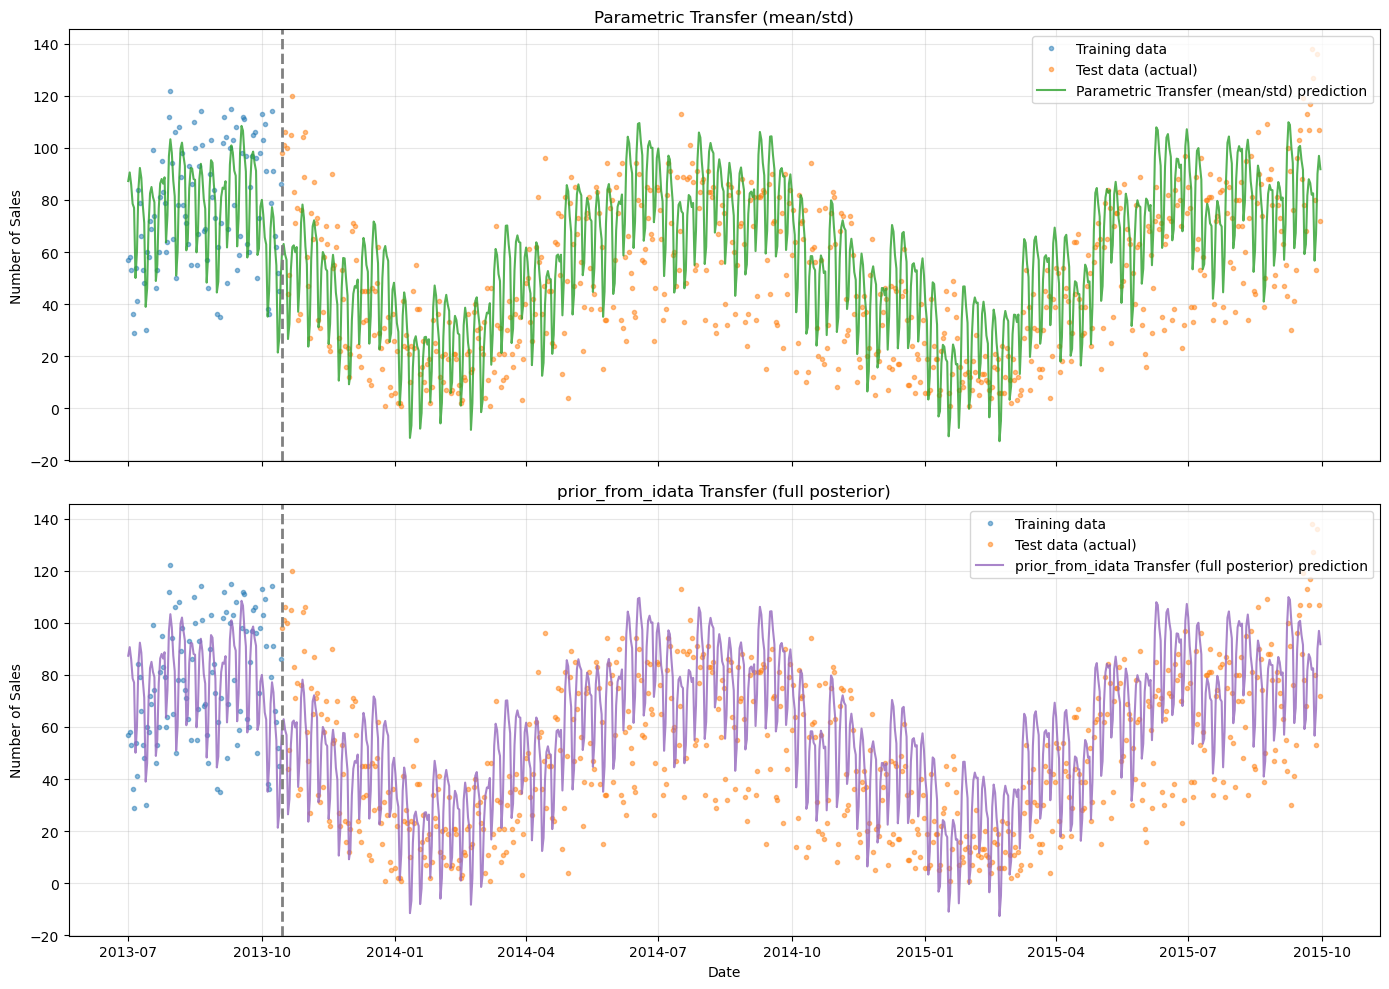

In [12]:
# Side-by-side comparison: parametric vs prior_from_idata
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

for ax, (model_name, pred, color) in zip(
    axes,
    [
        ("Parametric Transfer (mean/std)", transfer_param_pred, "C2"),
        ("prior_from_idata Transfer (full posterior)", transfer_pfi_pred, "C4"),
    ],
):
    ax.plot(
        sales_train["ds"],
        sales_train["y"],
        "C0o",
        markersize=3,
        alpha=0.5,
        label="Training data",
    )
    ax.plot(
        sales_test["ds"],
        sales_test["y"],
        "C1o",
        markersize=3,
        alpha=0.5,
        label="Test data (actual)",
    )
    ax.plot(
        pred["ds"],
        pred["yhat_0"],
        f"{color}-",
        linewidth=1.5,
        alpha=0.8,
        label=f"{model_name} prediction",
    )
    ax.axvline(train_test_date, color="gray", linestyle="--", linewidth=2)
    ax.set_title(f"{model_name}")
    ax.set_ylabel("Number of Sales")
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

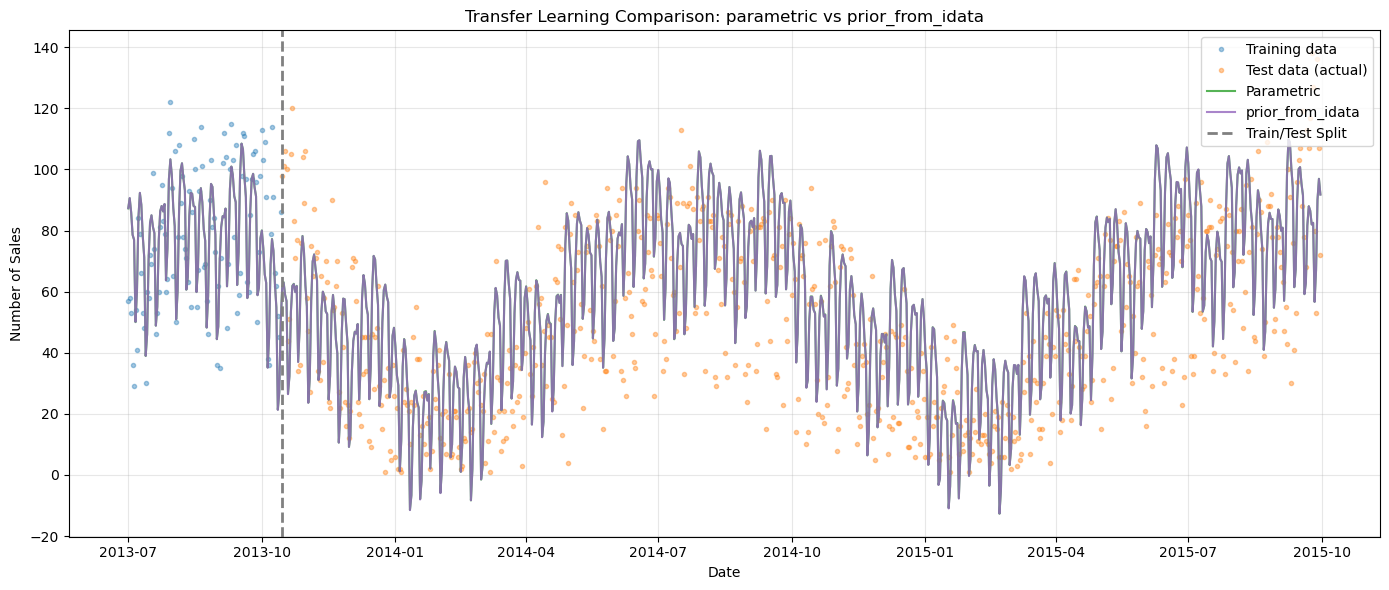

In [13]:
# Overlay both transfer learning approaches
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(
    sales_train["ds"],
    sales_train["y"],
    "C0o",
    markersize=3,
    alpha=0.4,
    label="Training data",
)
ax.plot(
    sales_test["ds"],
    sales_test["y"],
    "C1o",
    markersize=3,
    alpha=0.4,
    label="Test data (actual)",
)
ax.plot(
    transfer_param_pred["ds"],
    transfer_param_pred["yhat_0"],
    "C2-",
    linewidth=1.5,
    alpha=0.8,
    label="Parametric",
)
ax.plot(
    transfer_pfi_pred["ds"],
    transfer_pfi_pred["yhat_0"],
    "C4-",
    linewidth=1.5,
    alpha=0.8,
    label="prior_from_idata",
)

ax.axvline(
    train_test_date, color="gray", linestyle="--", linewidth=2, label="Train/Test Split"
)
ax.set_title("Transfer Learning Comparison: parametric vs prior_from_idata")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Sales")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Quantitative comparison
param_metrics = metrics(sales_test, transfer_param_pred, pool_type="complete")
pfi_metrics = metrics(sales_test, transfer_pfi_pred, pool_type="complete")

comparison_df = pd.DataFrame(
    {
        "Parametric": param_metrics.iloc[0],
        "prior_from_idata": pfi_metrics.iloc[0],
    },
).T

print("Test Set Metrics: parametric vs prior_from_idata")
print("=" * 55)
display(comparison_df.round(2))

Test Set Metrics: parametric vs prior_from_idata


,mse,rmse,mae,mape
Parametric,472.74,21.74,17.34,0.9
prior_from_idata,473.18,21.75,17.35,0.9


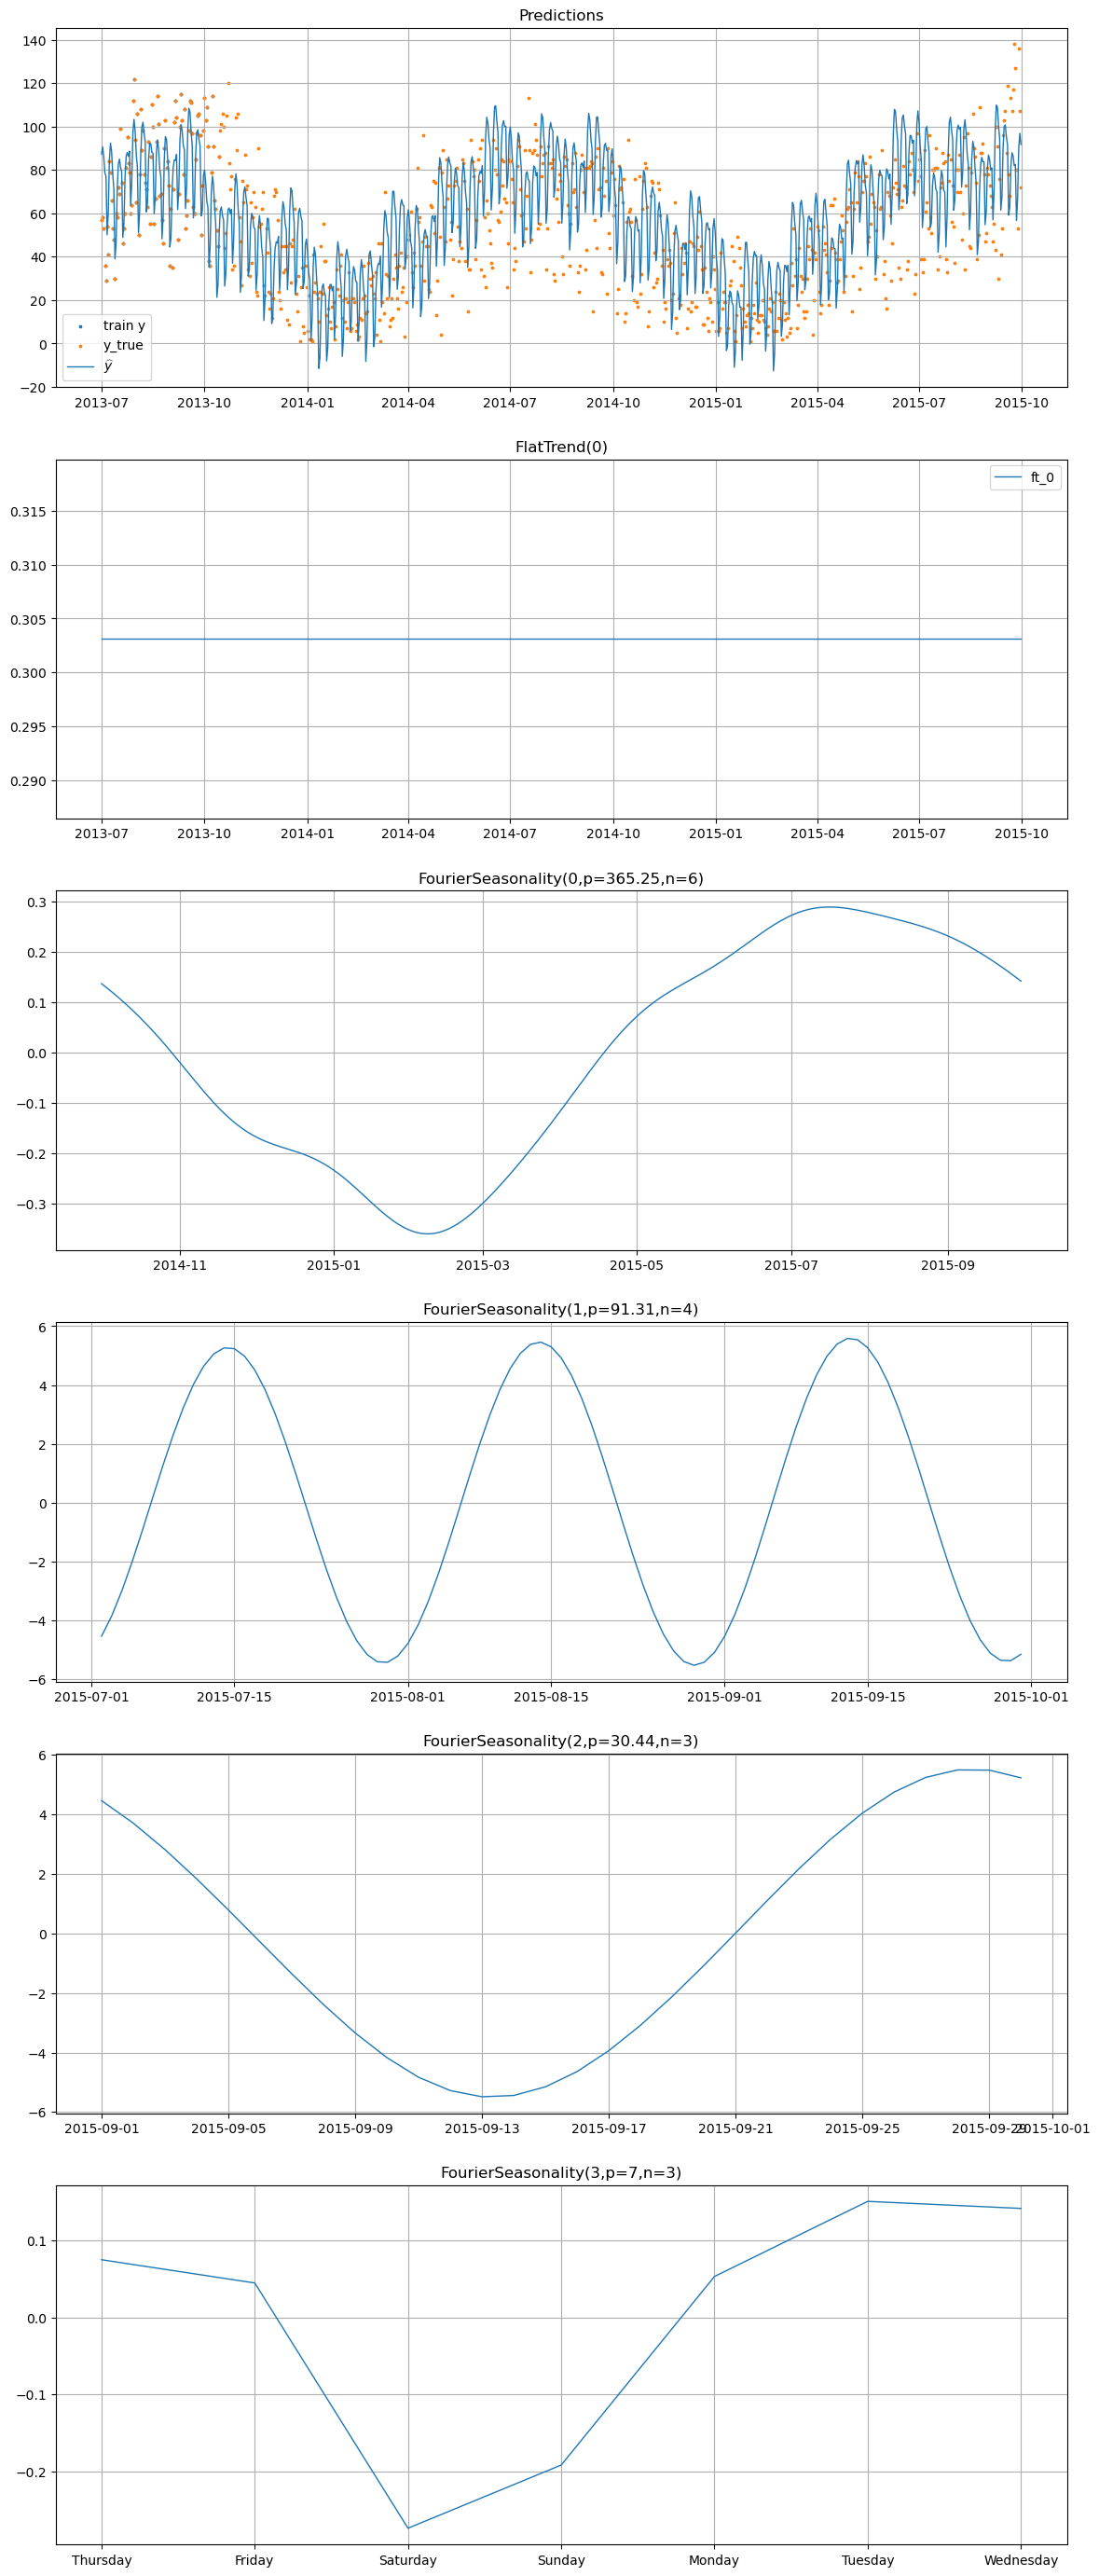

In [15]:
# Component decomposition for the prior_from_idata model
transfer_pfi_model.plot(transfer_pfi_pred, y_true=sales_df)

 ---

 ## Step 3: Combining Hierarchical Modeling with Transfer Learning

 Now we demonstrate the most powerful approach in vangja: **fitting a hierarchical model with partial pooling over both the temperature and bike sales series, while also informing the shared yearly seasonality prior with the temperature model's posterior**.

 ### Why is this powerful?

 In the previous step, we transferred knowledge from temperature to bike sales in a **one-to-one** fashion. But consider the general case: you might have:
 - One long "source" series (e.g., temperature with 3+ years of data)
 - Multiple short "target" series (e.g., bike sales from different stations, each with only a few months)

 Hierarchical modeling with partial pooling lets you:
 1. **Share seasonal information** across all series through a shared hyperprior
 2. **Inform the shared prior** with external knowledge via transfer learning
 3. **Allow individual deviations** — each series can still have its own seasonal amplitude and phase

 The result is a model where:
 - The shared yearly seasonality pattern is **warm-started** from the temperature posterior
 - **All series borrow strength** from each other through partial pooling
 - The temperature series (with years of data) provides a strong anchor for the seasonal shape
 - The short bike sales series can deviate from the shared pattern where the data supports it

 ### Setting up the hierarchical dataset

 We combine the temperature and (short) bike sales data into a single multi-series dataset. Each series gets a label in the `series` column.

In [16]:
# Create a multi-series dataset with both temperature and bike sales training data
temp_hier = temp_df.copy()
temp_hier["series"] = "temperature"

sales_hier = sales_train.copy()
sales_hier["series"] = "bike_sales"

sales_test_hier = sales_test.copy()
sales_test_hier["series"] = "bike_sales"

hier_df = pd.concat([temp_hier, sales_hier], ignore_index=True)

print(f"Hierarchical dataset shape: {hier_df.shape}")
print("\nSeries breakdown:")
for series_name in hier_df["series"].unique():
    series_data = hier_df[hier_df["series"] == series_name]
    print(
        f"  {series_name}: {len(series_data)} days "
        f"({series_data['ds'].min().date()} to {series_data['ds'].max().date()})"
    )

Hierarchical dataset shape: (928, 3)

Series breakdown:
  temperature: 822 days (2013-07-01 to 2015-09-30)
  bike_sales: 106 days (2013-07-01 to 2013-10-14)


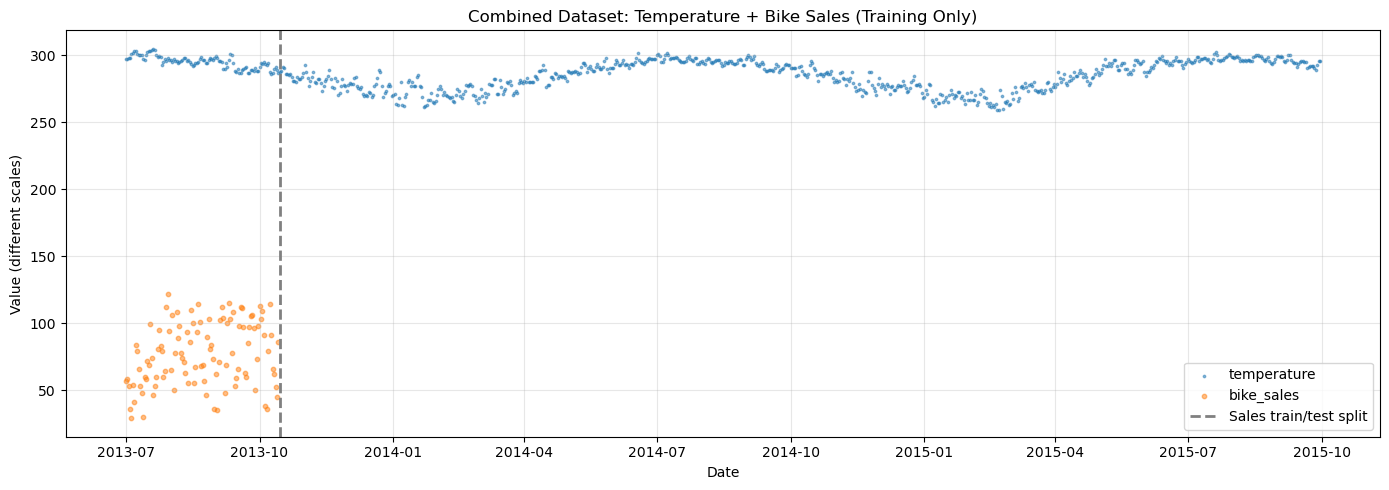


Note: Temperature (°F) and bike sales (counts) have very different scales.
scale_mode='individual' ensures each series is scaled independently.


In [17]:
# Visualize the combined dataset
fig, ax = plt.subplots(figsize=(14, 5))

for series_name, color, marker in [
    ("temperature", "C0", "."),
    ("bike_sales", "C1", "o"),
]:
    series_data = hier_df[hier_df["series"] == series_name]
    ax.scatter(
        series_data["ds"],
        series_data["y"],
        c=color,
        s=3 if marker == "." else 10,
        alpha=0.5,
        label=series_name,
    )

ax.axvline(
    train_test_date,
    color="gray",
    linestyle="--",
    linewidth=2,
    label="Sales train/test split",
)
ax.set_title("Combined Dataset: Temperature + Bike Sales (Training Only)")
ax.set_xlabel("Date")
ax.set_ylabel("Value (different scales)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nNote: Temperature (°F) and bike sales (counts) have very different scales.")
print("scale_mode='individual' ensures each series is scaled independently.")

 ### Fitting the Hierarchical Transfer Learning Model

 The model uses `pool_type="partial"` on the yearly seasonality with `tune_method="prior_from_idata"`. This means:
 1. The **shared** yearly seasonality hyperprior is set from the temperature model's posterior via `prior_from_idata`
 2. Each series (temperature and bike sales) gets its own yearly seasonality coefficients, drawn from a hierarchical distribution centered on the shared prior
 3. Other components (trend, weekly seasonality) use the default priors, but are also partially pooled

 The key insight: the shared yearly seasonality hyperprior is **not learned from scratch** — it's **warm-started** with the temperature model's posterior. Partial pooling then allows each series to deviate from this informed shared pattern proportionally to the data it brings to the table.

 Since the temperature series has ~3 years of data, it provides a strong signal about yearly seasonality. The bike sales series (only ~3 months) cannot strongly influence the shared pattern, but it can **deviate** from it where its own data supports a different shape. This is exactly the "borrowing strength" that hierarchical modeling excels at.

In [18]:
# Hierarchical model: partial pooling with transfer learning
hier_model = (
    FlatTrend(
        pool_type="individual"
    )  # Separate flat trend for each series (no pooling)
    + FourierSeasonality(
        period=365.25,
        series_order=6,
        pool_type="partial",
        tune_method="prior_from_idata",  # Shared prior from temperature posterior
        shrinkage_strength=10,
    )
    + FourierSeasonality(
        period=91.31, series_order=4, pool_type="partial", shrinkage_strength=10
    )
    + FourierSeasonality(
        period=30.44, series_order=3, pool_type="partial", shrinkage_strength=10
    )
    + FourierSeasonality(
        period=7, series_order=3, pool_type="partial", shrinkage_strength=10
    )
)

print("Fitting hierarchical model with partial pooling + transfer learning...")
print("  - FlatTrend: individual pooling (separate flat trend for each series)")
print(
    "  - Yearly seasonality: partial pooling + prior_from_idata (shared prior from temperature)"
)
print("  - Weekly seasonality: partial pooling (learned jointly from both series)")

hier_model.fit(
    hier_df,
    method="mapx",
    idata=temp_model.trace,
    t_scale_params=temp_model.t_scale_params,
    scaler="minmax",
    scale_mode="individual",
    sigma_pool_type="individual",
)

print(f"Group mapping: {hier_model.groups_}")
print("Done!")

Fitting hierarchical model with partial pooling + transfer learning...
  - FlatTrend: individual pooling (separate flat trend for each series)
  - Yearly seasonality: partial pooling + prior_from_idata (shared prior from temperature)
  - Weekly seasonality: partial pooling (learned jointly from both series)


Output()

Group mapping: {0: 'bike_sales', 1: 'temperature'}
Done!


In [19]:
# Generate predictions with horizon covering the test period
hier_pred = hier_model.predict(horizon=0, freq="D")

# Find the group code for bike_sales
sales_group = [k for k, v in hier_model.groups_.items() if v == "bike_sales"][0]
temp_group = [k for k, v in hier_model.groups_.items() if v == "temperature"][0]

print(f"bike_sales group code: {sales_group}")
print(f"temperature group code: {temp_group}")
print(f"\nPrediction columns: {[c for c in hier_pred.columns if 'yhat' in c]}")

bike_sales group code: 0
temperature group code: 1

Prediction columns: ['yhat_0', 'yhat_1']


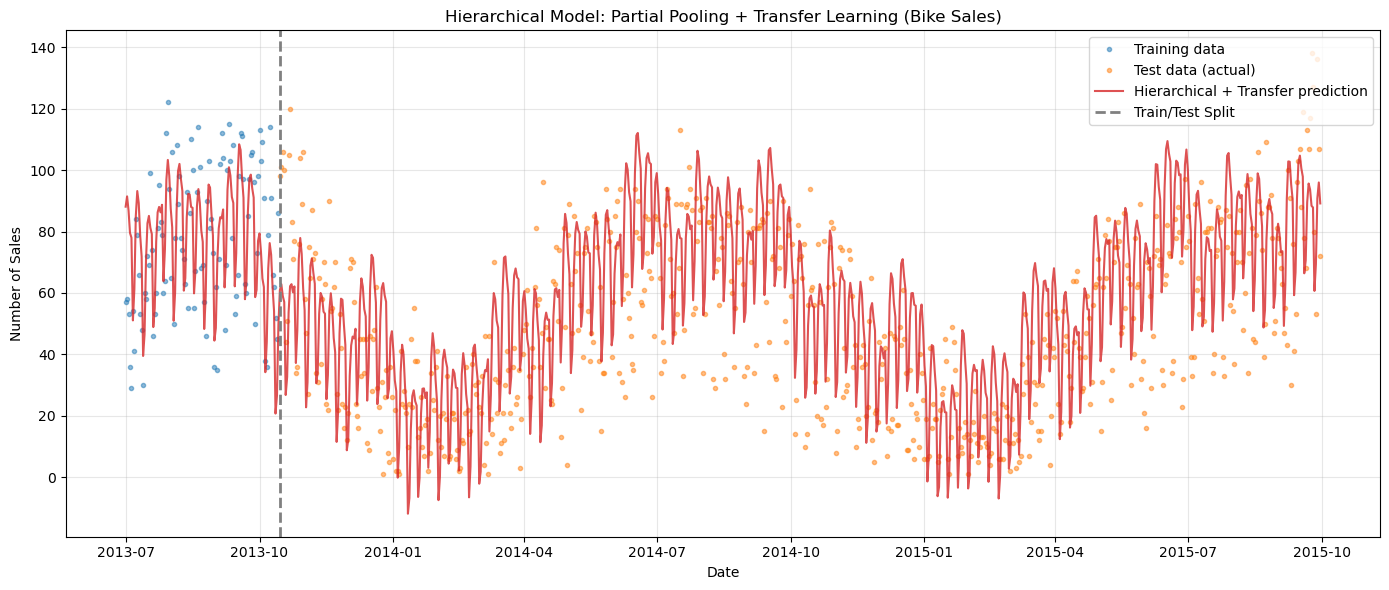

In [20]:
# Plot hierarchical model predictions for bike sales
fig, ax = plt.subplots(figsize=(14, 6))

# Training data
ax.plot(
    sales_train["ds"],
    sales_train["y"],
    "C0o",
    markersize=3,
    alpha=0.5,
    label="Training data",
)

# Test data (ground truth)
ax.plot(
    sales_test["ds"],
    sales_test["y"],
    "C1o",
    markersize=3,
    alpha=0.5,
    label="Test data (actual)",
)

# Hierarchical prediction (for bike_sales series)
ax.plot(
    hier_pred["ds"],
    hier_pred[f"yhat_{sales_group}"],
    "C3-",
    linewidth=1.5,
    alpha=0.8,
    label="Hierarchical + Transfer prediction",
)

ax.axvline(
    train_test_date, color="gray", linestyle="--", linewidth=2, label="Train/Test Split"
)
ax.set_title("Hierarchical Model: Partial Pooling + Transfer Learning (Bike Sales)")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Sales")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

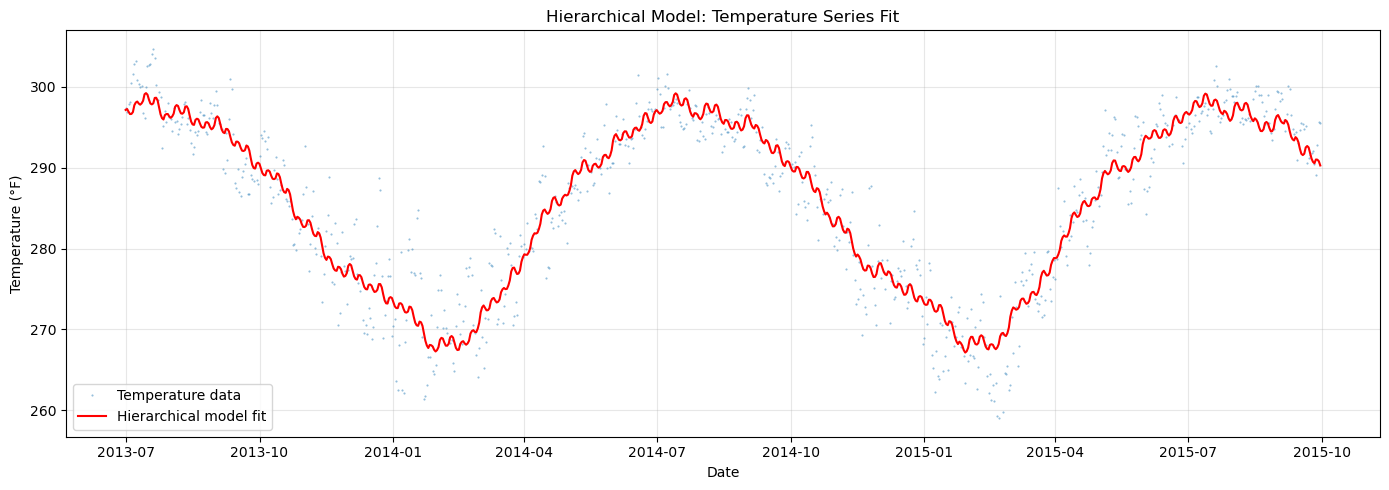

In [21]:
# Also visualize the temperature fit from the hierarchical model
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(
    temp_df["ds"],
    temp_df["y"],
    "C0.",
    markersize=1,
    alpha=0.5,
    label="Temperature data",
)
ax.plot(
    hier_pred["ds"],
    hier_pred[f"yhat_{temp_group}"],
    "r-",
    linewidth=1.5,
    label="Hierarchical model fit",
)

ax.set_title("Hierarchical Model: Temperature Series Fit")
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°F)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

=== Bike Sales Components ===


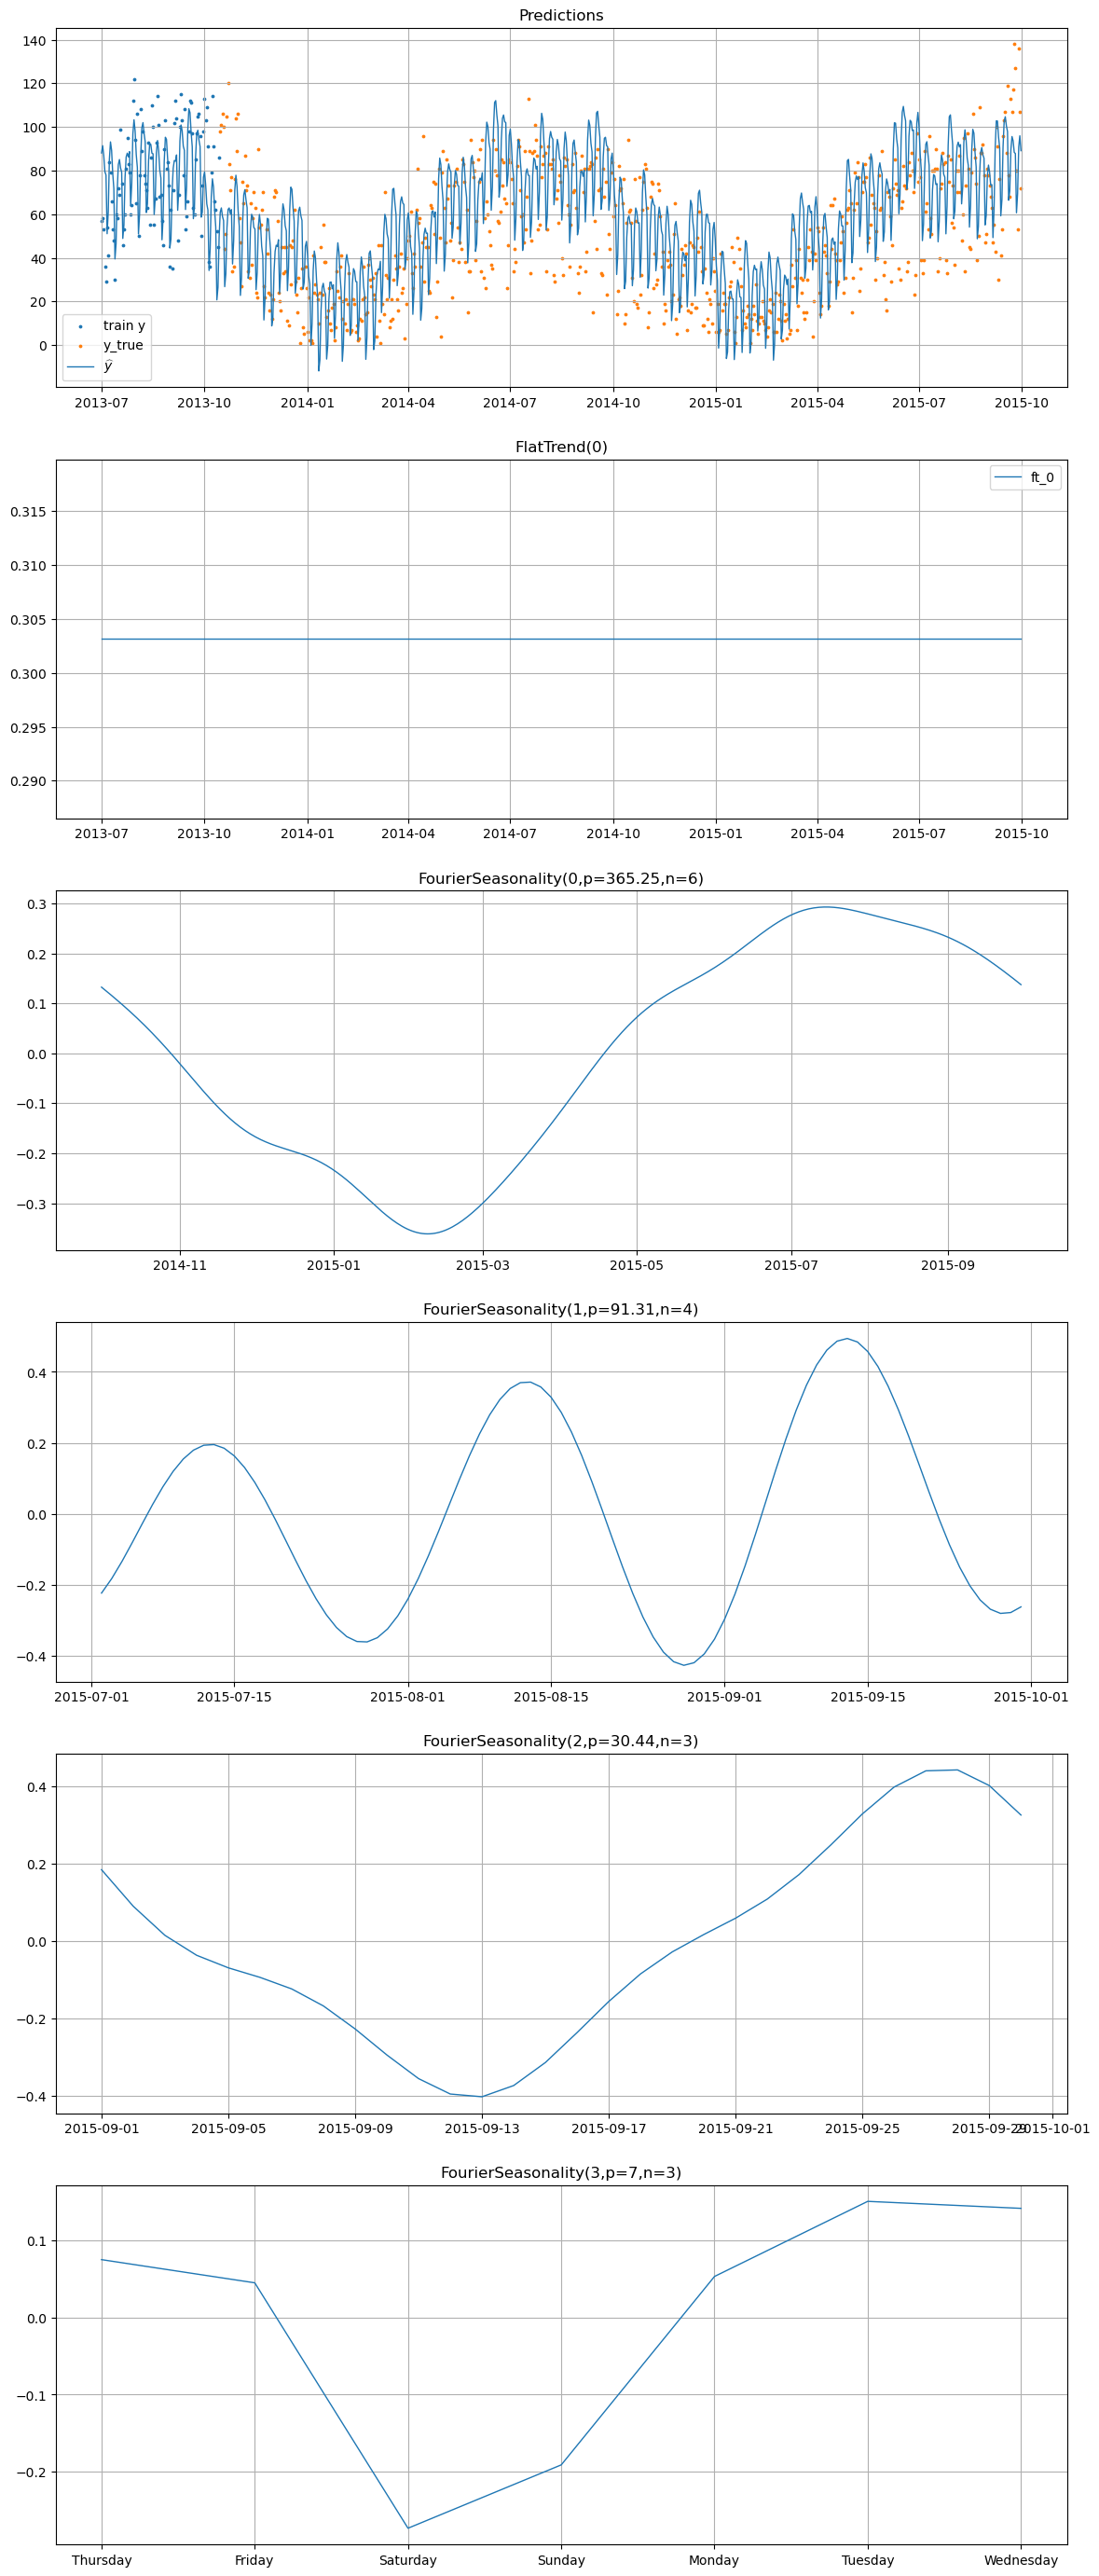

In [22]:
# Component decomposition for both series
print("=== Bike Sales Components ===")
hier_model.plot(hier_pred.iloc[:-1], series="bike_sales", y_true=sales_test_hier)

=== Temperature Components ===


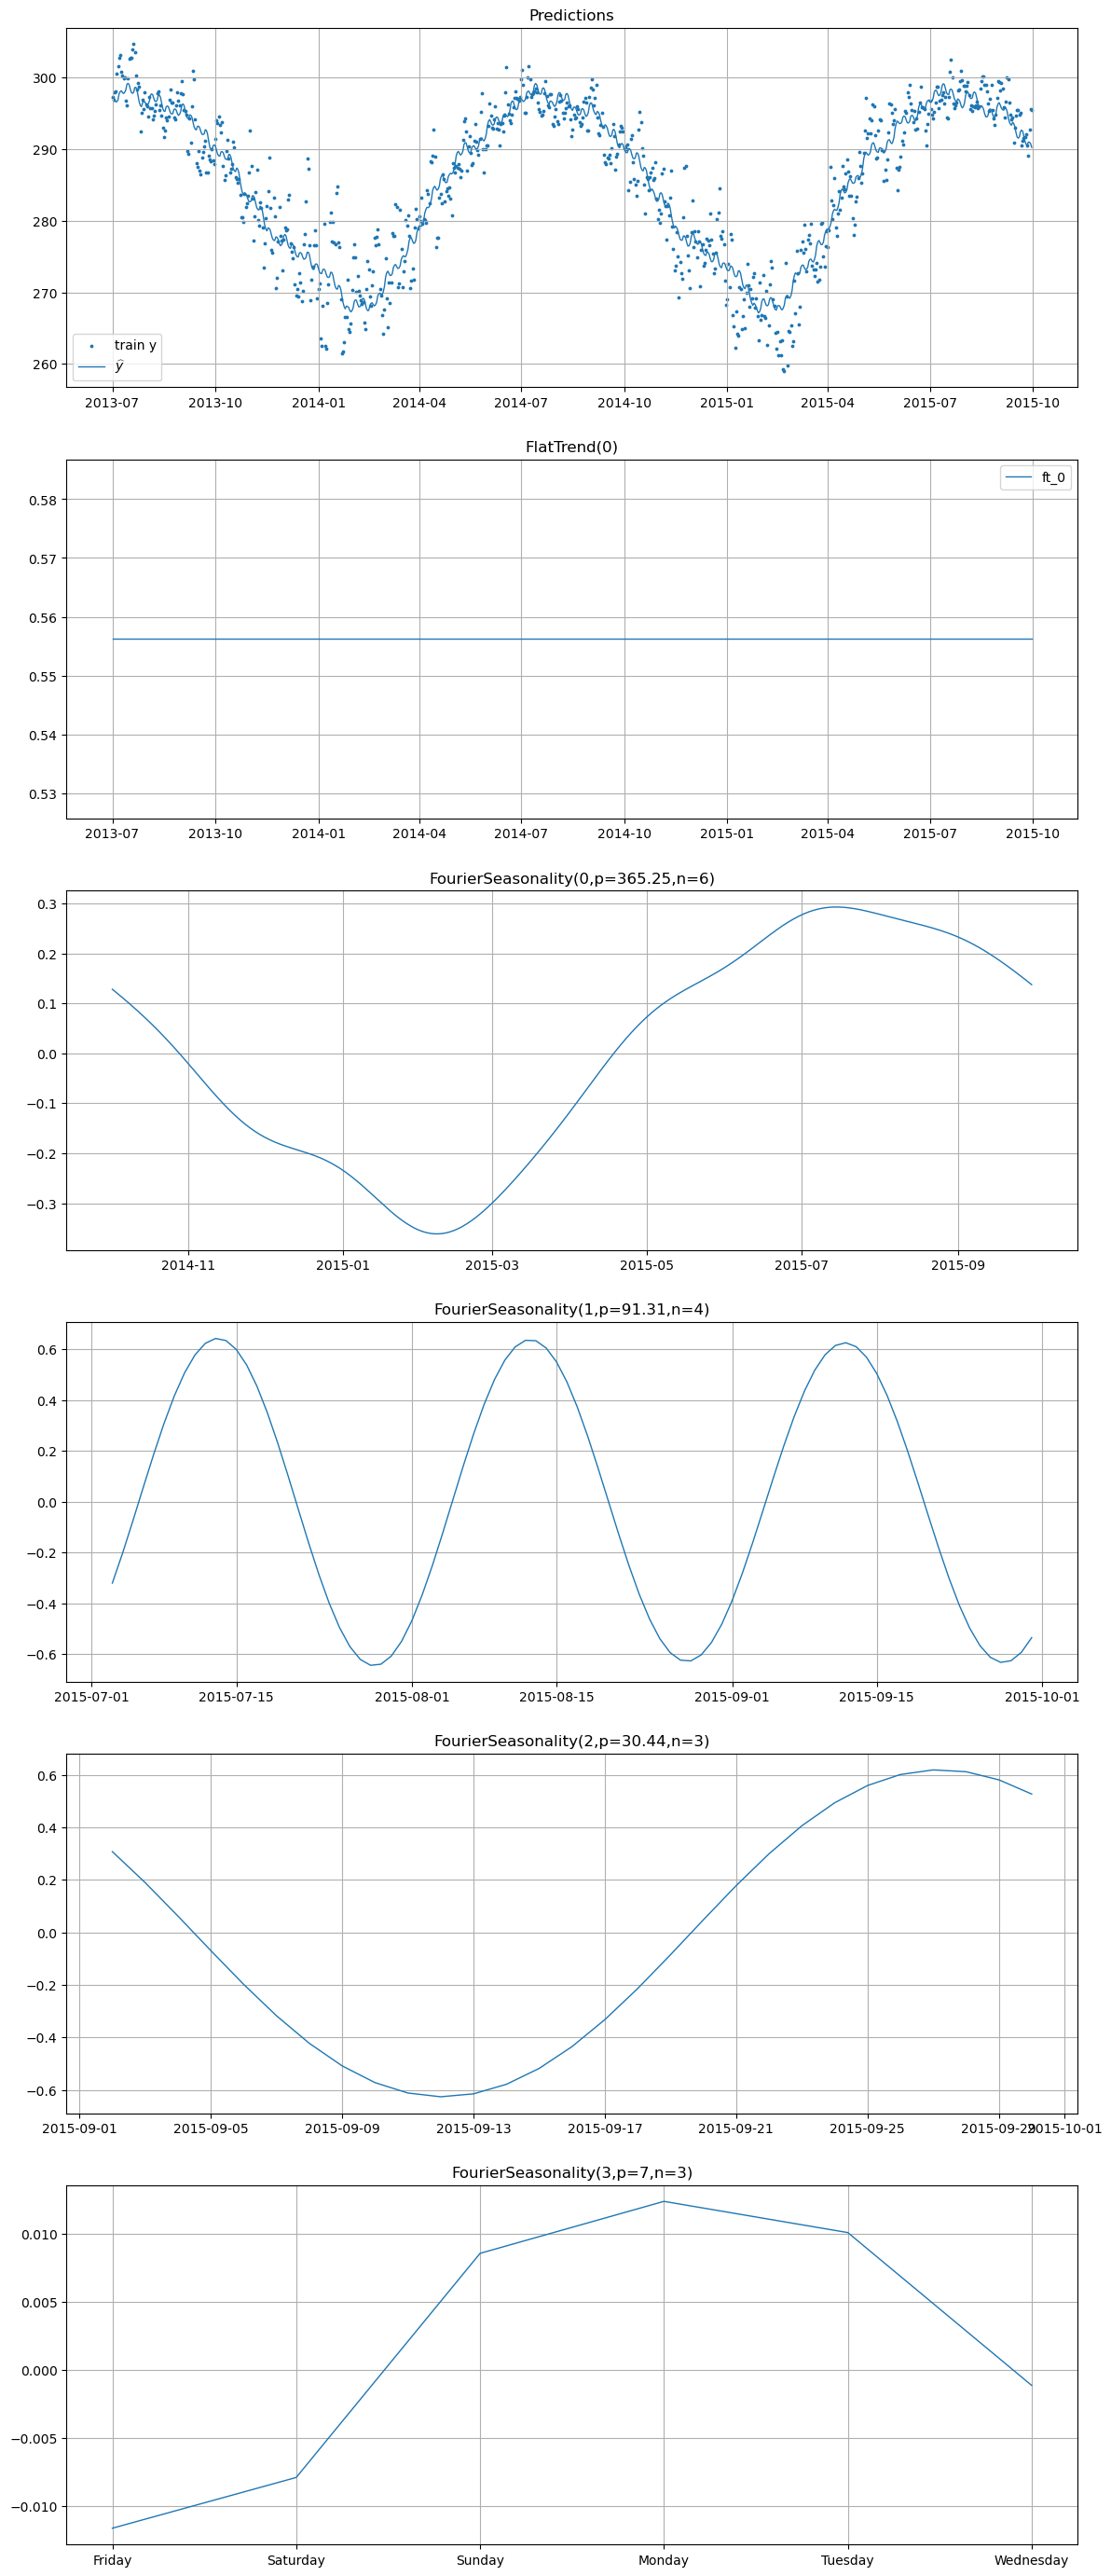

In [23]:
print("=== Temperature Components ===")
hier_model.plot(hier_pred, series="temperature")

 ---

 ## Full Comparison: All Approaches

 Let's compare all the approaches we've seen across this notebook and Chapter 07:
 1. **Parametric transfer** — `tune_method="parametric"` (Chapter 07): transfers mean/std only
 2. **`prior_from_idata` transfer** — `tune_method="prior_from_idata"`: transfers full posterior
 3. **Hierarchical + transfer** — partial pooling with `prior_from_idata`: jointly models both series

In [24]:
# Prepare hierarchical prediction for bike sales only
hier_sales_pred = hier_pred[["ds", f"yhat_{sales_group}"]].copy()
hier_sales_pred.columns = ["ds", "yhat_0"]

# Calculate metrics for all approaches
param_metrics = metrics(sales_test, transfer_param_pred, pool_type="complete")
pfi_metrics = metrics(sales_test, transfer_pfi_pred, pool_type="complete")
hier_metrics = metrics(sales_test, hier_sales_pred, pool_type="complete")

comparison_df = pd.DataFrame(
    {
        "Parametric Transfer": param_metrics.iloc[0],
        "prior_from_idata Transfer": pfi_metrics.iloc[0],
        "Hierarchical + Transfer": hier_metrics.iloc[0],
    },
).T

print("Test Set Metrics Comparison")
print("=" * 60)
display(comparison_df.round(2))

Test Set Metrics Comparison


,mse,rmse,mae,mape
Parametric Transfer,472.74,21.74,17.34,0.90
prior_from_idata Transfer,473.18,21.75,17.35,0.90
Hierarchical + Transfer,459.44,21.43,17.03,0.88


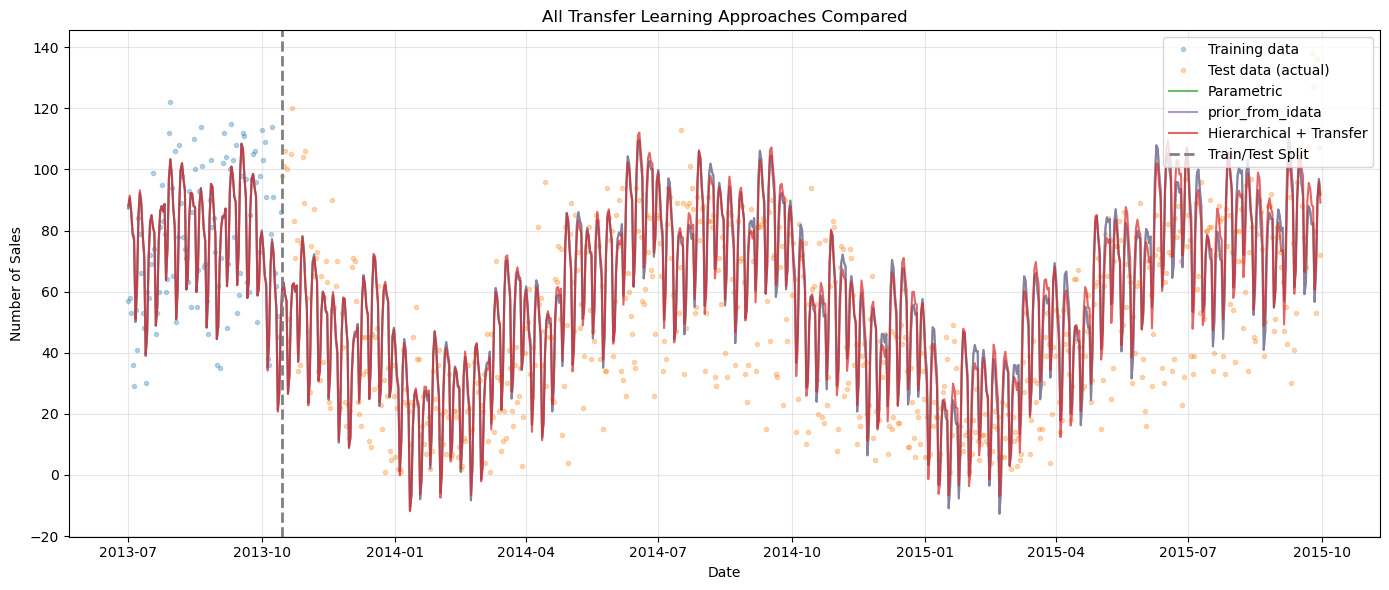

In [25]:
# Overlay all approaches
fig, ax = plt.subplots(figsize=(14, 6))

# Data
ax.plot(
    sales_train["ds"],
    sales_train["y"],
    "C0o",
    markersize=3,
    alpha=0.3,
    label="Training data",
)
ax.plot(
    sales_test["ds"],
    sales_test["y"],
    "C1o",
    markersize=3,
    alpha=0.3,
    label="Test data (actual)",
)

# Predictions from each approach
ax.plot(
    transfer_param_pred["ds"],
    transfer_param_pred["yhat_0"],
    "C2-",
    linewidth=1.5,
    alpha=0.7,
    label="Parametric",
)
ax.plot(
    transfer_pfi_pred["ds"],
    transfer_pfi_pred["yhat_0"],
    "C4-",
    linewidth=1.5,
    alpha=0.7,
    label="prior_from_idata",
)
ax.plot(
    hier_sales_pred["ds"],
    hier_sales_pred["yhat_0"],
    "C3-",
    linewidth=1.5,
    alpha=0.7,
    label="Hierarchical + Transfer",
)

ax.axvline(
    train_test_date, color="gray", linestyle="--", linewidth=2, label="Train/Test Split"
)
ax.set_title("All Transfer Learning Approaches Compared")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Sales")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

 ---

 ## Summary

 ### `parametric` vs `prior_from_idata`

 | Feature | `parametric` | `prior_from_idata` |
 |---------|-------------|-------------------|
 | What it captures | Marginal mean and std per parameter | Full joint posterior (covariance) |
 | Parameter correlations | Discarded | Preserved via multivariate Normal |
 | Implementation | `pm.Normal(mean, std)` per parameter | `pmx.utils.prior.prior_from_idata()` |
 | Computational cost | Slightly lower | Slightly higher (covariance estimation) |
 | When to prefer | Quick experiments, weakly correlated params | Production, correlated Fourier terms |

 ### Hierarchical + Transfer Learning

 Combining partial pooling with `prior_from_idata` is vangja's most powerful forecasting pattern for short time series:
 1. **Transfer learning** brings in external seasonal knowledge from a long related series
 2. **Partial pooling** allows the short target series to deviate from the transferred prior where its own data supports it
 3. **Joint modeling** means both series contribute to the shared seasonal hyperprior, with the long series naturally dominating due to having more data

 This approach is especially valuable when you have:
 - A long "reference" series with clear seasonality (e.g., weather, economic indicators)
 - One or more short "target" series that share seasonal drivers but lack enough history to learn them independently
 - A desire to quantify uncertainty about the seasonal transfer

 ### Further Reading

 - [pymc-extras prior_from_idata API docs](https://www.pymc.io/projects/extras/en/stable/generated/pymc_extras.utils.prior.prior_from_idata.html) — Full documentation for the `prior_from_idata` function
 - [Updating Priors (PyMC example)](https://www.pymc.io/projects/examples/en/latest/howto/updating_priors.html) — The original inspiration for iterative prior updating in PyMC
 - [Modeling Short Time Series with Prior Knowledge](https://minimizeregret.com/short-time-series-prior-knowledge) — Tim Radtke's original blog post

 ### What's Next

 **Chapter 09** documents several **advanced transfer learning options** — bidirectional changepoints, regularization potentials, phase alignment, and custom summary statistics — that provide fine-grained control over the transfer process.